# Q2.4: Implement MNIST classification

In [139]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import numpy as np
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [112]:

train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('../data', train=False, download=True, transform=transforms.ToTensor())
train_set = DataLoader(train_data, batch_size=1024, shuffle=True)
test_set = DataLoader(train_data, batch_size=1024, shuffle=True)

# Functions

In [152]:
import torch as th # MNIST images have dimension ( 1, 28, 28)

def model_fn():
    model = th.nn.Sequential(
        th.nn.Conv2d(1, 8, 5), # ( 8, 24, 24)
        th.nn.ReLU(), # ( 8, 24, 24)
        th.nn.MaxPool2d(2, 2), # ( 8, 12, 12)
        th.nn.Conv2d(8, 16, 5), # (16, 8, 8)
        th.nn.ReLU(), # (16, 8, 8)
        th.nn.MaxPool2d(2, 2), # (16, 4, 4)
        th.nn.Flatten(), # (16 * 4 * 4)
        th.nn.Linear(256, 128), # (128)
        th.nn.ReLU(), # (128)
        th.nn.Linear(128, 32), # ( 32)
        th.nn.ReLU(), # ( 32)
        th.nn.Linear(32, 10)
        ) # ( 10)
    return model

def train_model(
    model: th.nn.Sequential,
    train_loader: DataLoader,
    epochs: int,
    loss_fn: callable,
    test_loader: DataLoader= None,
    optimizer = None,
    learning_rate = 0.001,
    writer=SummaryWriter()
    ):
    if optimizer is None:
        optimizer = th.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    
    results = pd.DataFrame(index = range(epochs), columns=["Loss/train","Loss/test","Acc./test","Acc./test"])
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_acc = []

        for i, (x_batch, y_batch) in enumerate(train_loader, 0):
            # Get prediction
            
            y_pred = model(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            # Accuracy
            acc = (y_pred.max(dim=-1)[1] == y_batch).sum().item() / y_batch.shape[0]
            train_loss.append(loss.item())
            train_acc.append(acc)

            # Print progress
            if i % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
                    epoch + 1, i * len(x_batch), len(train_loader.dataset),
                    100. * i / len(train_loader), loss, acc))

        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)

        writer.add_scalar("Loss/train", epoch_train_loss, epoch)
        writer.add_scalar("Acc./train", epoch_train_acc, epoch)

        results.loc[epoch, "Loss/train"] = epoch_train_loss
        results.loc[epoch, "Acc./train"] = epoch_train_acc
    
        if test_loader is not None:
            model.eval()
            # Validation loop   
            test_loss = []
            test_acc = [] 
            total_correct = 0

            for x_batch, y_batch in test_loader:
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)
                # Calculate accuracy of prediction
                correct = (y_pred.max(dim=-1)[1] == y_batch)
                total_correct += correct.sum().item()
                acc = correct.sum().item() / y_batch.shape[0]
                test_loss.append(loss.item())
                test_acc.append(acc)

            epoch_test_loss = np.mean(test_loss)
            epoch_test_acc = np.mean(test_acc)

            writer.add_scalar("Loss/test", epoch_test_loss, epoch)
            writer.add_scalar("Acc./test", epoch_test_acc, epoch)
            results.loc[epoch, "Loss/test"] = epoch_test_loss
            results.loc[epoch, "Acc./test"] = epoch_test_acc
            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                epoch_test_loss, total_correct, len(test_loader.dataset), 100*epoch_test_acc))

        writer.flush()
    return model, results


# (a)

In [153]:
trained_model, results = train_model(model=model_fn(), train_loader=train_set, learning_rate=0.05, test_loader=test_set, epochs=10,loss_fn=th.nn.CrossEntropyLoss())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309038	Accuracy: 0.110352
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.300352	Accuracy: 0.105469
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.296599	Accuracy: 0.108398
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.284353	Accuracy: 0.206055
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.254225	Accuracy: 0.269531
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.056901	Accuracy: 0.506836

Test set: Average loss: 1.1834, Accuracy: 38226/60000 (64%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.149288	Accuracy: 0.641602
Train Epoch: 2 [10240/60000 (17%)]	Loss: 2.244161	Accuracy: 0.140625
Train Epoch: 2 [20480/60000 (34%)]	Loss: 1.860259	Accuracy: 0.351562
Train Epoch: 2 [30720/60000 (51%)]	Loss: 1.258613	Accuracy: 0.631836
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.845641	Accuracy: 0.739258
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.561333	Accuracy: 0.833008

Test set: Average loss: 0.3638, Accuracy: 53688/60000 (89%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.364790	Accuracy: 0.8

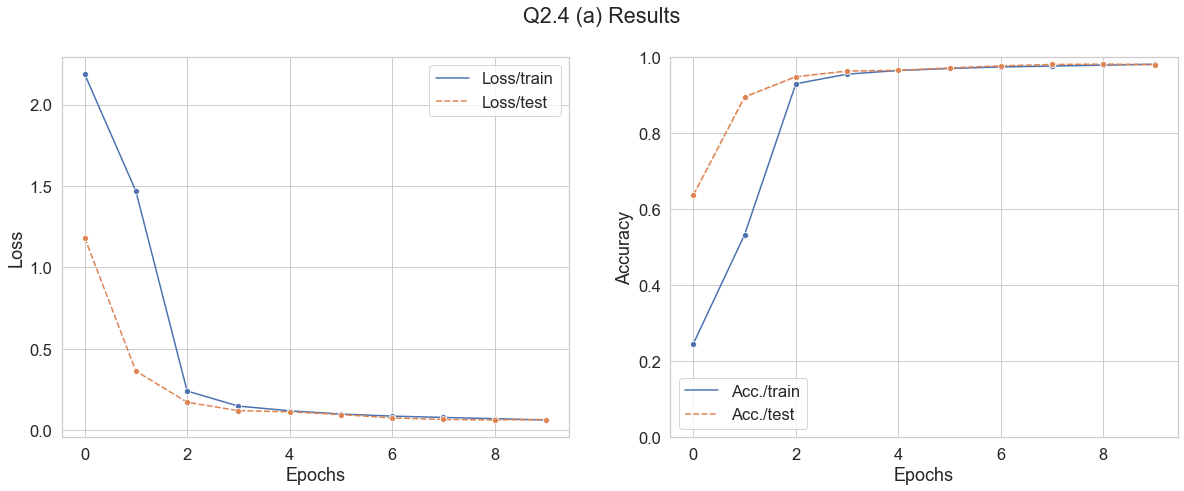

In [273]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(context="notebook",style="whitegrid", font_scale=1.5)

def plot_train_test(results, title):
    # Plot train/test loss/accuracy

    fig, axs = plt.subplots(1,2, figsize=(20,7))

    sns.lineplot(data=results[["Loss/train", "Loss/test"]], marker="o", ax=axs[0])
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    sns.lineplot(data=results[["Acc./train", "Acc./test"]], marker="o", ax=axs[1])
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_ylim([0,1.0])

    fig.suptitle(title)
    return fig

plot_train_test(results, title="Q2.4 (a) Results")
plt.show()

## (b)

In [187]:

def train_model_onehot(
    model: th.nn.Sequential,
    train_loader: DataLoader,
    epochs: int,
    loss_fn: callable,
    test_loader: DataLoader= None,
    optimizer = None,
    learning_rate = 0.001,
    writer=SummaryWriter()
    ):
    if optimizer is None:
        optimizer = th.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    
    results = pd.DataFrame(index = range(epochs), columns=["Loss/train","Loss/test","Acc./test","Acc./test"])
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_acc = []

        for i, (x_batch, y_batch) in enumerate(train_loader, 0):
            # Get prediction
            
            y_pred = model(x_batch)
            # One hot encoded
            y_batch = th.nn.functional.one_hot(y_batch, num_classes=y_pred.shape[1]).type(th.FloatTensor)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            # Accuracy
            # One hot version
            correct = th.argmax(y_pred, axis=1) == th.argmax(y_batch, axis=1)
            acc = th.sum(correct)/len(y_pred)
            train_loss.append(loss.item())
            train_acc.append(acc)

            # Print progress
            if i % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
                    epoch + 1, i * len(x_batch), len(train_loader.dataset),
                    100. * i / len(train_loader), loss, acc))

        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)

        writer.add_scalar("Loss/train", epoch_train_loss, epoch)
        writer.add_scalar("Acc./train", epoch_train_acc, epoch)

        results.loc[epoch, "Loss/train"] = epoch_train_loss
        results.loc[epoch, "Acc./train"] = epoch_train_acc
    
        if test_loader is not None:
            model.eval()
            # Validation loop   
            test_loss = []
            test_acc = [] 
            total_correct = 0

            for x_batch, y_batch in test_loader:
                
                # Perform forward pass with x_xor as input and y_pred as output variables
                y_pred = model(x_batch)
                y_batch = th.nn.functional.one_hot(y_batch, num_classes=y_pred.shape[1]).type(th.FloatTensor)
                loss = loss_fn(y_pred, y_batch)
                # Calculate accuracy of prediction
                correct = th.argmax(y_pred, axis=1) == th.argmax(y_batch, axis=1)
                total_correct += th.sum(correct)
                acc = th.sum(correct)/len(y_pred)
                test_loss.append(loss.item())
                test_acc.append(acc)

            epoch_test_loss = np.mean(test_loss)
            epoch_test_acc = np.mean(test_acc)

            writer.add_scalar("Loss/test", epoch_test_loss, epoch)
            writer.add_scalar("Acc./test", epoch_test_acc, epoch)
            results.loc[epoch, "Loss/test"] = epoch_test_loss
            results.loc[epoch, "Acc./test"] = epoch_test_acc
            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                epoch_test_loss, total_correct, len(test_loader.dataset), 100*epoch_test_acc))

        writer.flush()
    return model, results


In [188]:
trained_model_onehot, results_onehot = train_model_onehot(model=model_fn(), train_loader=train_set, learning_rate=0.05, test_loader=test_set, epochs=10,loss_fn=th.nn.MSELoss())


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.122234	Accuracy: 0.097656
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.097946	Accuracy: 0.087891
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.090129	Accuracy: 0.181641
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.090634	Accuracy: 0.190430
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.089302	Accuracy: 0.274414
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.088947	Accuracy: 0.221680

Test set: Average loss: 0.0886, Accuracy: 18271/60000 (30%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.088637	Accuracy: 0.296875
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.088037	Accuracy: 0.402344
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.087527	Accuracy: 0.456055
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.086844	Accuracy: 0.494141
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.085945	Accuracy: 0.483398
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.084821	Accuracy: 0.499023

Test set: Average loss: 0.0833, Accuracy: 32224/60000 (54%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.083292	Accuracy: 0.5

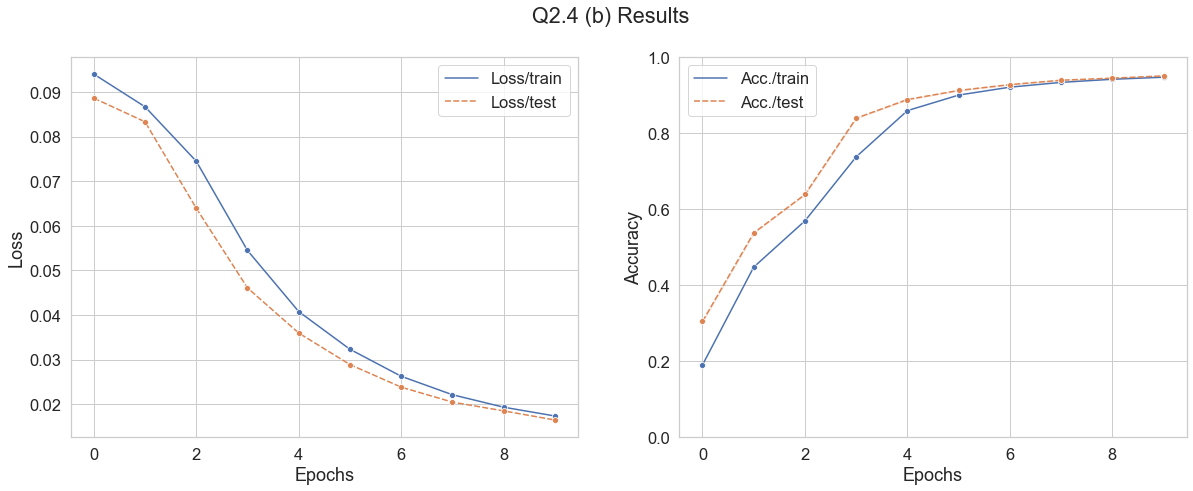

In [274]:
plot_train_test(results_onehot, title="Q2.4 (b) Results")
plt.show()

## (c)

In [199]:
def regressor_fn():
    model = th.nn.Sequential(
        th.nn.Conv2d(1, 8, 5), # ( 8, 24, 24)
        th.nn.ReLU(), # ( 8, 24, 24)
        th.nn.MaxPool2d(2, 2), # ( 8, 12, 12)
        th.nn.Conv2d(8, 16, 5), # (16, 8, 8)
        th.nn.ReLU(), # (16, 8, 8)
        th.nn.MaxPool2d(2, 2), # (16, 4, 4)
        th.nn.Flatten(), # (16 * 4 * 4)
        th.nn.Linear(256, 128), # (128)
        th.nn.ReLU(), # (128)
        th.nn.Linear(128, 32), # ( 32)
        th.nn.ReLU(), # ( 32)
        th.nn.Linear(32, 1)
    )
    return model
regressor_fn()

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=32, bias=True)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=1, bias=True)
)

In [258]:
import torch as th # MNIST images have dimension ( 1, 28, 28)

def train_regressor(
    model: th.nn.Sequential,
    train_loader: DataLoader,
    epochs: int,
    loss_fn: callable,
    test_loader: DataLoader= None,
    optimizer = None,
    learning_rate = 0.001,
    writer=SummaryWriter()
    ):
    if optimizer is None:
        optimizer = th.optim.SGD(model.parameters(), lr=learning_rate)

    
    results = pd.DataFrame(index = range(epochs), columns=["Loss/train","Loss/test","Acc./test","Acc./test"])
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_acc = []

        for i, (x_batch, y_batch) in enumerate(train_loader, 0):
            # Get prediction
            y_batch = y_batch.type(th.FloatTensor)
            y_pred = model(x_batch).flatten()
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            # Accuracy
            acc = (th.isclose(y_pred.round(), y_batch)).sum().item() / y_batch.shape[0]
            train_loss.append(loss.item())
            train_acc.append(acc)

            # Print progress
            if i % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
                    epoch + 1, i * len(x_batch), len(train_loader.dataset),
                    100. * i / len(train_loader), loss, acc))

        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)

        writer.add_scalar("Loss/train", epoch_train_loss, epoch)
        writer.add_scalar("Acc./train", epoch_train_acc, epoch)

        results.loc[epoch, "Loss/train"] = epoch_train_loss
        results.loc[epoch, "Acc./train"] = epoch_train_acc
    
        if test_loader is not None:
            model.eval()
            # Validation loop   
            test_loss = []
            test_acc = [] 
            total_correct = 0

            for x_batch, y_batch in test_loader:
                # Perform forward pass with x_xor as input and y_pred as output variables
                y_batch = y_batch.type(th.FloatTensor)
                y_pred = model(x_batch).flatten()
                loss = loss_fn(y_pred, y_batch)
                # Calculate accuracy of prediction
                correct = th.isclose(y_pred.round(), y_batch)
                total_correct += correct.sum().item()
                acc = correct.sum().item() / y_batch.shape[0]
                test_loss.append(loss.item())
                test_acc.append(acc)

            epoch_test_loss = np.mean(test_loss)
            epoch_test_acc = np.mean(test_acc)

            writer.add_scalar("Loss/test", epoch_test_loss, epoch)
            writer.add_scalar("Acc./test", epoch_test_acc, epoch)
            results.loc[epoch, "Loss/test"] = epoch_test_loss
            results.loc[epoch, "Acc./test"] = epoch_test_acc
            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                epoch_test_loss, total_correct, len(test_loader.dataset), 100*epoch_test_acc))

        writer.flush()
    return model, results


In [263]:
reg, results_regressor = train_regressor(model=regressor_fn(), train_loader=train_set, learning_rate=0.01, test_loader=test_set, epochs=50,loss_fn=th.nn.MSELoss())

Train Epoch: 1 [0/60000 (0%)]	Loss: 26.244036	Accuracy: 0.102539
Train Epoch: 1 [10240/60000 (17%)]	Loss: 10.979454	Accuracy: 0.094727
Train Epoch: 1 [20480/60000 (34%)]	Loss: 10.961178	Accuracy: 0.098633
Train Epoch: 1 [30720/60000 (51%)]	Loss: 7.921905	Accuracy: 0.113281
Train Epoch: 1 [40960/60000 (68%)]	Loss: 7.637411	Accuracy: 0.079102
Train Epoch: 1 [51200/60000 (85%)]	Loss: 8.065365	Accuracy: 0.153320

Test set: Average loss: 5.0439, Accuracy: 7073/60000 (12%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 5.073312	Accuracy: 0.107422
Train Epoch: 2 [10240/60000 (17%)]	Loss: 6.706359	Accuracy: 0.145508
Train Epoch: 2 [20480/60000 (34%)]	Loss: 5.488219	Accuracy: 0.156250
Train Epoch: 2 [30720/60000 (51%)]	Loss: 3.822854	Accuracy: 0.179688
Train Epoch: 2 [40960/60000 (68%)]	Loss: 4.653603	Accuracy: 0.158203
Train Epoch: 2 [51200/60000 (85%)]	Loss: 3.868165	Accuracy: 0.164062

Test set: Average loss: 3.3770, Accuracy: 12751/60000 (21%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 3.362459	Accuracy: 0

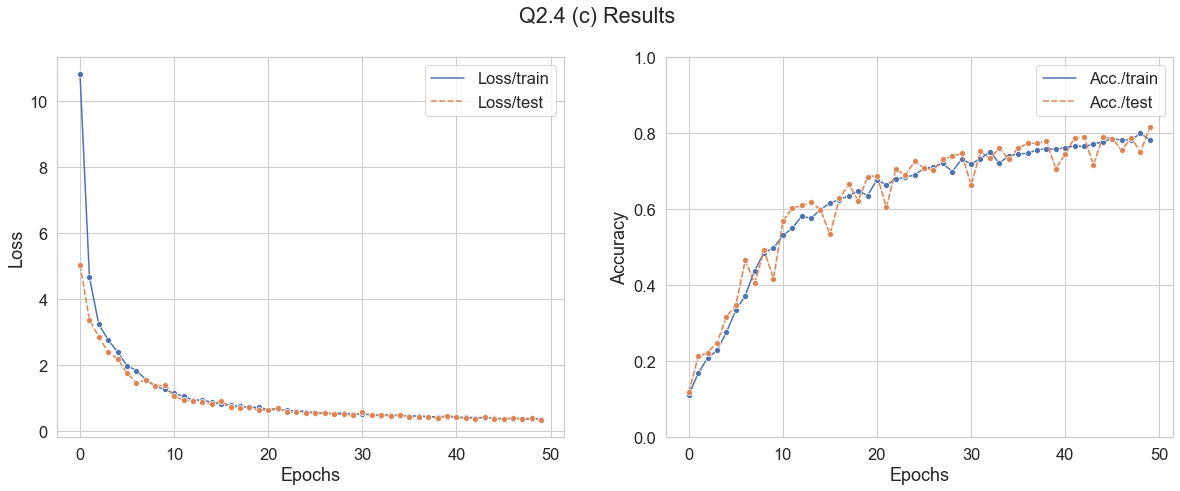

In [275]:
plot_train_test(results_regressor, title="Q2.4 (c) Results")
plt.show()

In [267]:
class FourPointFiveTransform(th.nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
    
    def forward(self, x:th.Tensor): # x.shape (batch, input_dim)
        x = 4.5*x + 4.5
        return x
    
    def backward(self, dupstream):
        dx = dupstream*4.5
        return dx

def regressor_modified_fn():
    model = th.nn.Sequential(
        th.nn.Conv2d(1, 8, 5), # ( 8, 24, 24)
        th.nn.ReLU(), # ( 8, 24, 24)
        th.nn.MaxPool2d(2, 2), # ( 8, 12, 12)
        th.nn.Conv2d(8, 16, 5), # (16, 8, 8)
        th.nn.ReLU(), # (16, 8, 8)
        th.nn.MaxPool2d(2, 2), # (16, 4, 4)
        th.nn.Flatten(), # (16 * 4 * 4)
        th.nn.Linear(256, 128), # (128)
        th.nn.ReLU(), # (128)
        th.nn.Linear(128, 32), # ( 32)
        th.nn.ReLU(), # ( 32)
        th.nn.Linear(32, 1),
        FourPointFiveTransform(1,1)
    )
    return model
regressor_modified_fn()

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=32, bias=True)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=1, bias=True)
  (12): FourPointFiveTransform()
)

In [268]:
reg, results_modified_regressor = train_regressor(model=regressor_modified_fn(), train_loader=train_set, learning_rate=0.01, test_loader=test_set, epochs=50,loss_fn=th.nn.MSELoss())

Train Epoch: 1 [0/60000 (0%)]	Loss: 8.074825	Accuracy: 0.099609
Train Epoch: 1 [10240/60000 (17%)]	Loss: 8.282312	Accuracy: 0.085938
Train Epoch: 1 [20480/60000 (34%)]	Loss: 7.836471	Accuracy: 0.077148
Train Epoch: 1 [30720/60000 (51%)]	Loss: 7.702311	Accuracy: 0.082031
Train Epoch: 1 [40960/60000 (68%)]	Loss: 6.204608	Accuracy: 0.069336
Train Epoch: 1 [51200/60000 (85%)]	Loss: 8.119047	Accuracy: 0.098633

Test set: Average loss: 7.7149, Accuracy: 3521/60000 (6%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 7.668564	Accuracy: 0.064453
Train Epoch: 2 [10240/60000 (17%)]	Loss: 6.075728	Accuracy: 0.110352
Train Epoch: 2 [20480/60000 (34%)]	Loss: 3.834686	Accuracy: 0.135742
Train Epoch: 2 [30720/60000 (51%)]	Loss: 3.765803	Accuracy: 0.178711
Train Epoch: 2 [40960/60000 (68%)]	Loss: 3.116315	Accuracy: 0.261719
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.817008	Accuracy: 0.253906

Test set: Average loss: 2.7334, Accuracy: 17276/60000 (29%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 3.003283	Accuracy: 0.282

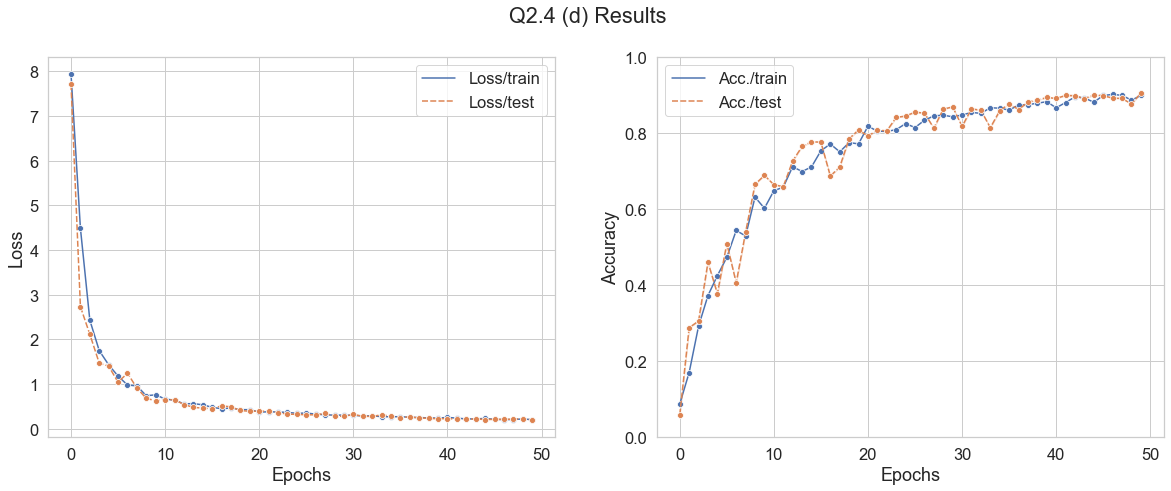

In [276]:
plot_train_test(results_modified_regressor, title="Q2.4 (d) Results")
plt.show()

The learning becomes faster as the gradient descent is started from the middle of the label space (labels $\in$ [0,9]) instead of the edge ($\beta$). It also becomes faster as the results are scaled towards the values of the numbers.

Bonus: Scaling and centering the data would have the same effect.